In [18]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import mido
from utils.midi_tools02 import mid2arry, convert2binary, arry2mid
from utils.data_processing import get_tonnetz_edge_index, slice_temporal_data
from model.model_ver01 import SimpleMLP,SimpleLSTM,SimpleLSTM_encoder,SimpleGCN

ImportError: cannot import name 'SimpleLSTM_encoder' from 'model.model_ver01' (c:\Users\mange\Desktop\l45-music-gnn\model\model_ver01.py)

## Prepare Data

In [2]:
import os
data_path = "data/2018"
midi_list = os.listdir(data_path)
print(midi_list[:10])

['MIDI-Unprocessed_Chamber2_MID--AUDIO_09_R3_2018_wav--1.midi', 'MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R3_2018_wav--1.midi', 'MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R3_2018_wav--2.midi', 'MIDI-Unprocessed_Chamber4_MID--AUDIO_11_R3_2018_wav--1.midi', 'MIDI-Unprocessed_Chamber5_MID--AUDIO_18_R3_2018_wav--1.midi', 'MIDI-Unprocessed_Chamber6_MID--AUDIO_20_R3_2018_wav--1.midi', 'MIDI-Unprocessed_Chamber6_MID--AUDIO_20_R3_2018_wav--2.midi', 'MIDI-Unprocessed_Recital1-3_MID--AUDIO_01_R1_2018_wav--1.midi', 'MIDI-Unprocessed_Recital1-3_MID--AUDIO_01_R1_2018_wav--2.midi', 'MIDI-Unprocessed_Recital1-3_MID--AUDIO_01_R1_2018_wav--3.midi']


In [3]:
train_data = []
for data in midi_list[:10]:
  midi = mido.MidiFile(os.path.join(data_path,data))
  midi_arr = mid2arry(midi)
  midi_bin_arr = convert2binary(midi_arr)
  midi_tensor = torch.tensor(midi_bin_arr).to(torch.float)
  train_data += slice_temporal_data(midi_tensor, window_size=10)
print(len(train_data), train_data[0][0].shape, train_data[0][1].shape)

6926816 torch.Size([128, 10]) torch.Size([128, 1])


In [4]:
num_notes = train_data[0][0].shape[0]
edge_index = get_tonnetz_edge_index(num_notes)

In [5]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

train_data = train_data[:3000]
data_X = torch.stack([d[0] for d in train_data])
y = torch.stack([d[1] for d in train_data])
data_Y = y.squeeze(-1)
print("X = ",data_X.shape,"Y = ",data_Y.shape)

X_train, X_test, y_train, y_test = train_test_split(data_X, data_Y, test_size=0.2, random_state=42)
print("After split, train size: ",X_train.shape, y_train.shape)

train_dataset = TensorDataset(X_train, y_train)
valid_dataset = TensorDataset(X_test, y_test)

batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

X =  torch.Size([3000, 128, 10]) Y =  torch.Size([3000, 128])
After split, train size:  torch.Size([2400, 128, 10]) torch.Size([2400, 128])


## Start Training

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Helper function

In [7]:
def train_and_eval_model(net,optimizer,criterion,epoch,train_dataloader,valid_dataloader):
    train_loss_list = []
    test_loss_list = []

    for i in range(epoch):
        print("\n------------------------------------------------------")
        print("epoch {}/{}".format(i+1,epoch))
        train_loss = 0
        test_loss = 0
        
        net.train()
        for data,label in train_dataloader:
            data,label = data.to(device),label.to(device)
            optimizer.zero_grad()
            y_pred_prob = net(data)
            loss = criterion(y_pred_prob,label)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        batch_train_loss = train_loss/len(train_dataloader)
        
        net.eval()
        with torch.no_grad():
            for data,label in valid_dataloader:
                data = data.to(device)
                label = label.to(device)
                y_pred_prob = net(data)
                loss = criterion(y_pred_prob,label)
                test_loss += loss.item()
        batch_test_loss = test_loss/len(valid_dataloader)
        print("Train_Loss: {:.4f} Test_Loss: {:.4f}".format(batch_train_loss, batch_test_loss))

        train_loss_list.append(batch_train_loss)
        test_loss_list.append(batch_test_loss)
    return train_loss_list, test_loss_list

In [8]:
def plot_learning(epoch,train_loss_list,test_loss_list):
    plt.figure()
    plt.title("Train and Test Loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.plot(range(1,epoch+1),train_loss_list,color="b",linestyle="-",label="train_loss")
    plt.plot(range(1,epoch+1),test_loss_list,color="r",linestyle="--",label="test_loss")
    plt.legend()
    plt.show()

In [9]:
criterion = nn.BCEWithLogitsLoss()
epoch = 10
window_size = 10

### Simple MLP model


------------------------------------------------------
epoch 1/10
Train_Loss: 0.6307 Test_Loss: 0.5516

------------------------------------------------------
epoch 2/10
Train_Loss: 0.4570 Test_Loss: 0.3532

------------------------------------------------------
epoch 3/10
Train_Loss: 0.2421 Test_Loss: 0.1415

------------------------------------------------------
epoch 4/10
Train_Loss: 0.0842 Test_Loss: 0.0462

------------------------------------------------------
epoch 5/10
Train_Loss: 0.0307 Test_Loss: 0.0205

------------------------------------------------------
epoch 6/10
Train_Loss: 0.0151 Test_Loss: 0.0117

------------------------------------------------------
epoch 7/10
Train_Loss: 0.0091 Test_Loss: 0.0078

------------------------------------------------------
epoch 8/10
Train_Loss: 0.0062 Test_Loss: 0.0058

------------------------------------------------------
epoch 9/10
Train_Loss: 0.0046 Test_Loss: 0.0046

------------------------------------------------------
epoch 10

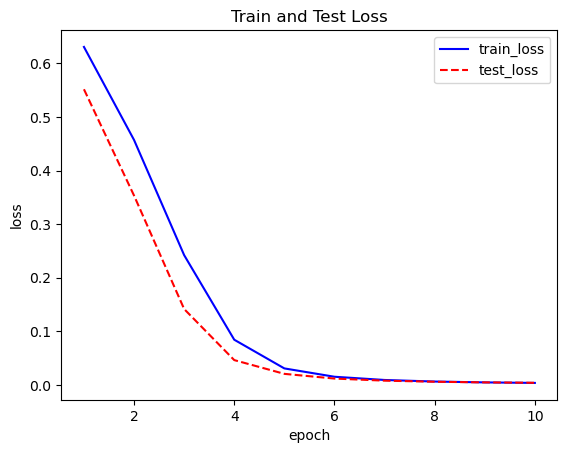

In [10]:
net = SimpleMLP(window_size).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
train_loss_list, test_loss_list = train_and_eval_model(net,optimizer,criterion,epoch,train_dataloader,valid_dataloader)
plot_learning(epoch,train_loss_list,test_loss_list)

### Simple LSTM model


------------------------------------------------------
epoch 1/10
Train_Loss: 0.3828 Test_Loss: 0.0955

------------------------------------------------------
epoch 2/10
Train_Loss: 0.0756 Test_Loss: 0.0548

------------------------------------------------------
epoch 3/10
Train_Loss: 0.0376 Test_Loss: 0.0253

------------------------------------------------------
epoch 4/10
Train_Loss: 0.0163 Test_Loss: 0.0106

------------------------------------------------------
epoch 5/10
Train_Loss: 0.0078 Test_Loss: 0.0064

------------------------------------------------------
epoch 6/10
Train_Loss: 0.0053 Test_Loss: 0.0050

------------------------------------------------------
epoch 7/10
Train_Loss: 0.0043 Test_Loss: 0.0043

------------------------------------------------------
epoch 8/10
Train_Loss: 0.0037 Test_Loss: 0.0038

------------------------------------------------------
epoch 9/10
Train_Loss: 0.0031 Test_Loss: 0.0032

------------------------------------------------------
epoch 10

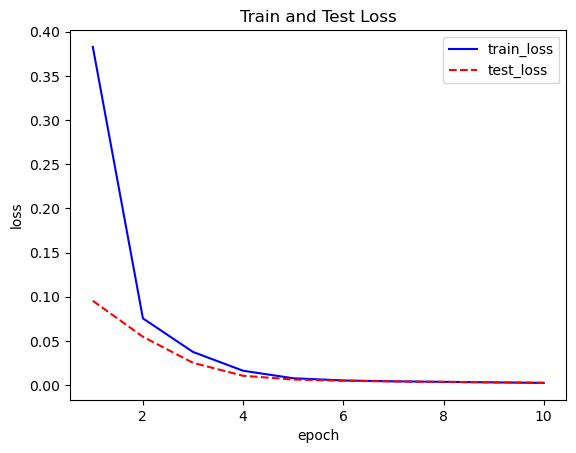

In [17]:
net = SimpleLSTM(window_size).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
train_loss_list, test_loss_list = train_and_eval_model(net,optimizer,criterion,epoch,train_dataloader,valid_dataloader)
plot_learning(epoch,train_loss_list,test_loss_list)

In [ ]:
net = SimpleLSTM_encoder(window_size).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
train_loss_list, test_loss_list = train_and_eval_model(net,optimizer,criterion,epoch,train_dataloader,valid_dataloader)
plot_learning(epoch,train_loss_list,test_loss_list)

### Simple GCN model


------------------------------------------------------
epoch 1/10
Train_Loss: 0.5480 Test_Loss: 0.3780

------------------------------------------------------
epoch 2/10
Train_Loss: 0.2005 Test_Loss: 0.0912

------------------------------------------------------
epoch 3/10
Train_Loss: 0.0658 Test_Loss: 0.0534

------------------------------------------------------
epoch 4/10
Train_Loss: 0.0493 Test_Loss: 0.0476

------------------------------------------------------
epoch 5/10
Train_Loss: 0.0462 Test_Loss: 0.0460

------------------------------------------------------
epoch 6/10
Train_Loss: 0.0451 Test_Loss: 0.0452

------------------------------------------------------
epoch 7/10
Train_Loss: 0.0445 Test_Loss: 0.0448

------------------------------------------------------
epoch 8/10
Train_Loss: 0.0442 Test_Loss: 0.0445

------------------------------------------------------
epoch 9/10
Train_Loss: 0.0440 Test_Loss: 0.0444

------------------------------------------------------
epoch 10

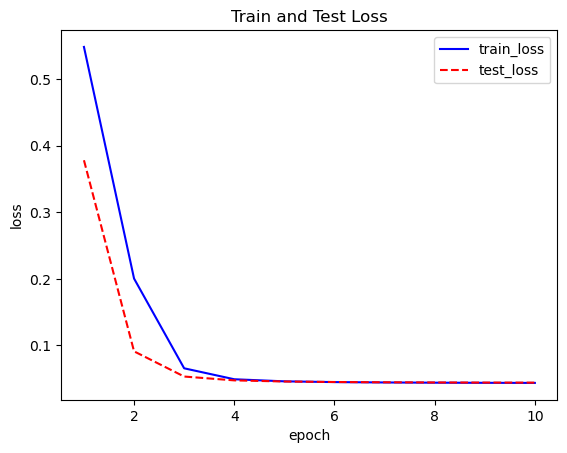

In [20]:
net = SimpleGCN(window_size,hidden_dim=32,edge_index=edge_index.to(device)).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
train_loss_list, test_loss_list = train_and_eval_model(net,optimizer,criterion,epoch,train_dataloader,valid_dataloader)
plot_learning(epoch,train_loss_list,test_loss_list)